In [6]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
pd.set_option('display.max_columns', None)
# optional
import seaborn as sns; sns.set()
import math
from sklearn.model_selection import GridSearchCV
from sklearn.mixture import GaussianMixture
from sklearn.ensemble import GradientBoostingClassifier
from scipy.sparse.linalg import svds
from functools import partial


train = pd.read_table("../Data_competition/X_train.txt", sep=',',header=None)
test = pd.read_table("../Data_competition/X_test.txt",sep=',',header=None)
cible=pd.read_table("../Data_competition/y_train.txt",sep=',',header=None)
header=pd.read_csv("../Data_competition/header.csv",sep=',',header=None)

feature_name=header.drop(header.columns[[2]], axis=1)
feature_name=feature_name.drop(feature_name.index[[56,49,30,20,14,0,38]])[3]
feature_name
feature_name2=header.drop(header.columns[[2]], axis=1)
feature_name2=feature_name2.drop(feature_name2.index[[56,49,30,20,14,0,38]])[1]
                                 
train_via_def=train
train_via_def.columns=feature_name2
test_via_def=test
test_via_def.columns=feature_name2

frames=[train_via_def,test_via_def]
alldata= pd.concat(frames,keys=['train','test'])



##########################


def emsvd(Y, k=None, tol=1E-3, maxiter=None):
    """
    Approximate SVD on data with missing values via expectation-maximization

    Inputs:
    -----------
    Y:          (nobs, ndim) data matrix, missing values denoted by NaN/Inf
    k:          number of singular values/vectors to find (default: k=ndim)
    tol:        convergence tolerance on change in trace norm
    maxiter:    maximum number of EM steps to perform (default: no limit)

    Returns:
    -----------
    Y_hat:      (nobs, ndim) reconstructed data matrix
    mu_hat:     (ndim,) estimated column means for reconstructed data
    U, s, Vt:   singular values and vectors (see np.linalg.svd and 
                scipy.sparse.linalg.svds for details)
    """

    if k is None:
        svdmethod = partial(np.linalg.svd, full_matrices=False)
    else:
        svdmethod = partial(svds, k=k)
    if maxiter is None:
        maxiter = np.inf

    # initialize the missing values to their respective column means
    mu_hat = np.nanmean(Y, axis=0, keepdims=1)
    valid = np.isfinite(Y)
    Y_hat = np.where(valid, Y, mu_hat)

    halt = False
    ii = 1
    v_prev = 0

    while not halt:

        # SVD on filled-in data
        U, s, Vt = svdmethod(Y_hat - mu_hat)

        # impute missing values
        Y_hat[~valid] = (U.dot(np.diag(s)).dot(Vt) + mu_hat)[~valid]

        # update bias parameter
        mu_hat = Y_hat.mean(axis=0, keepdims=1)

        # test convergence using relative change in trace norm
        v = s.sum()
        if ii >= maxiter or ((v - v_prev) / v_prev) < tol:
            halt = True
        ii += 1
        v_prev = v

    return Y_hat, mu_hat, U, s, Vt
    
    

alldata_fill_svd=pd.DataFrame(emsvd(alldata)[0],columns=feature_name2)
alldata_fill_svd['x51']=alldata_fill_svd['x51']-2011
                     
###########

train_nan_svd=alldata_fill_svd.iloc[0:2400]
test_nan_svd=alldata_fill_svd.iloc[2400:4001]

//anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:80: FutureWarning: in the future, boolean array-likes will be handled as a boolean array index


In [11]:
tuned_parameters = [{'loss': ['deviance'],
                    'max_features':[5,10,20,50],
                    'max_depth':[3,5,10,30],
                    'n_estimators':[100,300,500],'learning_rate':[0.1,0.3,0.5]}]

clf = GridSearchCV(GradientBoostingClassifier(), tuned_parameters, cv=10,verbose=2)
clf.fit(train_nan_svd, cible[0].values)


print("Best parameters set found on development set:")
print()
print(clf.best_params_)
print()

print("Grid scores on development set:")
print()
means = clf.cv_results_['mean_test_score']
stds = clf.cv_results_['std_test_score']
for mean, std, params in zip(means, stds, clf.cv_results_['params']):
    print("%0.3f (+/-%0.03f) for %r"
            % (mean, std * 2, params))
print()

Fitting 10 folds for each of 144 candidates, totalling 1440 fits
[CV] max_depth=3, loss=deviance, n_estimators=100, learning_rate=0.1, max_features=5 
[CV]  max_depth=3, loss=deviance, n_estimators=100, learning_rate=0.1, max_features=5, total=   0.1s
[CV] max_depth=3, loss=deviance, n_estimators=100, learning_rate=0.1, max_features=5 


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.2s remaining:    0.0s


[CV]  max_depth=3, loss=deviance, n_estimators=100, learning_rate=0.1, max_features=5, total=   0.2s
[CV] max_depth=3, loss=deviance, n_estimators=100, learning_rate=0.1, max_features=5 
[CV]  max_depth=3, loss=deviance, n_estimators=100, learning_rate=0.1, max_features=5, total=   0.2s
[CV] max_depth=3, loss=deviance, n_estimators=100, learning_rate=0.1, max_features=5 
[CV]  max_depth=3, loss=deviance, n_estimators=100, learning_rate=0.1, max_features=5, total=   0.1s
[CV] max_depth=3, loss=deviance, n_estimators=100, learning_rate=0.1, max_features=5 
[CV]  max_depth=3, loss=deviance, n_estimators=100, learning_rate=0.1, max_features=5, total=   0.1s
[CV] max_depth=3, loss=deviance, n_estimators=100, learning_rate=0.1, max_features=5 
[CV]  max_depth=3, loss=deviance, n_estimators=100, learning_rate=0.1, max_features=5, total=   0.1s
[CV] max_depth=3, loss=deviance, n_estimators=100, learning_rate=0.1, max_features=5 
[CV]  max_depth=3, loss=deviance, n_estimators=100, learning_rate

[Parallel(n_jobs=1)]: Done 1440 out of 1440 | elapsed: 23.7min finished


Best parameters set found on development set:

{'max_depth': 5, 'loss': 'deviance', 'n_estimators': 500, 'learning_rate': 0.3, 'max_features': 5}

Grid scores on development set:

0.949 (+/-0.042) for {'max_depth': 3, 'loss': 'deviance', 'n_estimators': 100, 'learning_rate': 0.1, 'max_features': 5}
0.954 (+/-0.042) for {'max_depth': 3, 'loss': 'deviance', 'n_estimators': 300, 'learning_rate': 0.1, 'max_features': 5}
0.958 (+/-0.041) for {'max_depth': 3, 'loss': 'deviance', 'n_estimators': 500, 'learning_rate': 0.1, 'max_features': 5}
0.949 (+/-0.041) for {'max_depth': 3, 'loss': 'deviance', 'n_estimators': 100, 'learning_rate': 0.1, 'max_features': 10}
0.956 (+/-0.039) for {'max_depth': 3, 'loss': 'deviance', 'n_estimators': 300, 'learning_rate': 0.1, 'max_features': 10}
0.960 (+/-0.044) for {'max_depth': 3, 'loss': 'deviance', 'n_estimators': 500, 'learning_rate': 0.1, 'max_features': 10}
0.946 (+/-0.043) for {'max_depth': 3, 'loss': 'deviance', 'n_estimators': 100, 'learning_rate': 0

In [12]:
clf.best_score_

0.96583333333333332

In [57]:
model=GradientBoostingClassifier(max_depth=5,loss='deviance',n_estimators=500,learning_rate=0.3,max_features=5)

In [58]:
model.fit(train_nan_svd,cible[0].values)

GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.3, loss='deviance', max_depth=5,
              max_features=5, max_leaf_nodes=None,
              min_impurity_split=1e-07, min_samples_leaf=1,
              min_samples_split=2, min_weight_fraction_leaf=0.0,
              n_estimators=500, presort='auto', random_state=None,
              subsample=1.0, verbose=0, warm_start=False)

In [37]:
model.score(train_nan_svd,cible[0].values)

1.0

In [15]:
y_pred_clf=model.predict(test_nan_svd)

index=range(len(y_pred_clf))
data=np.transpose([index,y_pred_clf])
a = pd.DataFrame(data=data,columns=['Id','Prediction'])
a.to_csv("submission6.csv", sep=",",index=False)  

In [88]:
importance=pd.DataFrame(model.feature_importances_.reshape((51,1)),index=feature_name2)

In [107]:
serie=importance[0].copy()

In [118]:
a=serie.order(ascending=False)

//anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:1: FutureWarning: order is deprecated, use sort_values(...)
  if __name__ == '__main__':


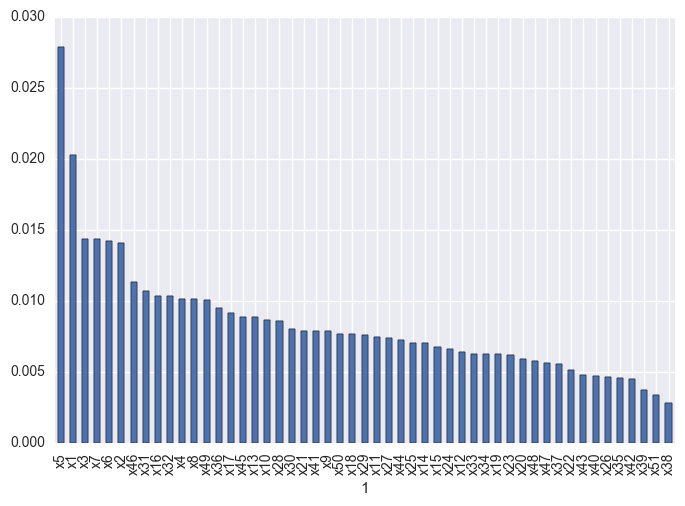

In [122]:
a.plot(kind='bar')
plt.show()

//anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:2: FutureWarning: sort(....) is deprecated, use sort_index(.....)
  from ipykernel import kernelapp as app


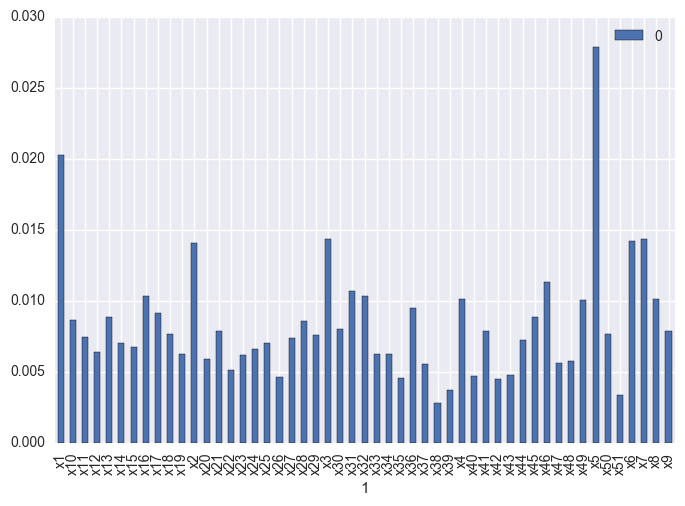

In [84]:
plt.figure()
importance.sort(ascending=True).plot(kind='bar')
plt.show()

In [27]:
from sklearn.neural_network import MLPClassifier

In [52]:
model=MLPClassifier(hidden_layer_sizes=(7,5,3, 2),activation='relu',max_iter=1000)

In [53]:
model.fit(train_nan_svd,cible[0].values)

MLPClassifier(activation='relu', alpha=0.0001, batch_size='auto', beta_1=0.9,
       beta_2=0.999, early_stopping=False, epsilon=1e-08,
       hidden_layer_sizes=(7, 5, 3, 2), learning_rate='constant',
       learning_rate_init=0.001, max_iter=1000, momentum=0.9,
       nesterovs_momentum=True, power_t=0.5, random_state=None,
       shuffle=True, solver='adam', tol=0.0001, validation_fraction=0.1,
       verbose=False, warm_start=False)

In [55]:
model.score(train_nan_svd,cible[0].values)

0.97541666666666671